In [149]:
import pandas as pd

import numpy as np

import os,sys

from shapely.geometry import Point, Polygon

import copy

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score 

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import time

from scipy.stats import pearsonr


from scipy.stats import rv_continuous

import scipy


from scipy.optimize import curve_fit

from scipy.stats import gamma


from scipy.stats import shapiro


from scipy.stats import mannwhitneyu

from scipy.stats import ks_2samp

import matplotlib.gridspec as gridspec

import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl

import matplotlib.animation 



In [150]:
'''Load Data'''

Load_Path='./Data/Collection/'

Save_Path='./Data/Estimation/'

Clustered_DF=pd.read_csv(os.path.join(Load_Path,'Clustered_DF.csv'))

Clustered_DF=Clustered_DF.drop(columns=['Unnamed: 0'])

Clustered_DF


Driver_DF=Clustered_DF[['Driver_id','label']]

Driver_DF=Driver_DF.drop_duplicates(subset=['Driver_id','label'])


## 01 The number of Shifts

In [17]:
Stat=Clustered_DF.groupby(['Total Number of Shifts','label']).count()

Stat=Stat[['Driver_id']]

Stat=Stat.rename(columns={'Driver_id':'Driver Number'})

Stat['Transition']=Stat.index

Stat['Total Number of Shifts']=Stat.apply(lambda x:x['Transition'][0],axis=1)

Stat['label']=Stat.apply(lambda x:x['Transition'][1],axis=1)

Stat=Stat.reset_index(drop=True)

Stat=Stat[['Total Number of Shifts','label','Driver Number']]


Sum_Stat=Clustered_DF.groupby(['label']).count()

Sum_Stat=Sum_Stat[['Driver_id']]

Sum_Stat['label']=Sum_Stat.index

Sum_Stat=Sum_Stat.reset_index(drop=True)

Sum_Stat=Sum_Stat.rename(columns={'Driver_id':'Sum Number'})

Stat=Stat.merge(Sum_Stat,on='label')

Stat['prob']=Stat.apply(lambda x:round(x['Driver Number']/x['Sum Number'],2),axis=1)

Labels=['A','B','C']

The_number_of_Shifts={l:{} for l in Labels}

for idx,row in Stat.iterrows():
    
    label=row['label']
    
    number=row['Total Number of Shifts']
    
    prob=row['prob']
    
    if prob >=0.01:
    
        The_number_of_Shifts[label][number]=prob

np.save(os.path.join(Save_Path,'The_number_of_Shifts.npy'),The_number_of_Shifts)

The_number_of_Shifts

{'A': {1.0: 0.51, 2.0: 0.37, 3.0: 0.11, 4.0: 0.01},
 'B': {1.0: 0.86, 2.0: 0.13, 3.0: 0.01},
 'C': {1.0: 0.8, 2.0: 0.2}}

## 02 First Shift Start Time

In [79]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)*(1/np.sqrt(2*np.pi)/sigma)

def gauss_1(x,mu1,sigma1,A):
    return gauss(x,mu1,sigma1,A)
def gauss_2(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def gauss_3(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

def gauss_4(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3,mu4,sigma4,A4):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)

def Get_fit_without_guess(X,Y,multiplier):
    
    params =curve_fit(eval("gauss_%s"%str(multiplier)),X,Y, maxfev=100000000)[0]
        
    Y_=eval("gauss_%s"%str(multiplier))(X,*params)
    
    return Y_,params

def Get_fit_with_guess(X,Y,multiplier,expected):
    
    params =curve_fit(eval("gauss_%s"%str(multiplier)),X,Y,p0=expected,maxfev=100000000)[0]
        
    Y_=eval("gauss_%s"%str(multiplier))(X,*params)
    
    return Y_,params

def Get_expected(Array,Cut_points):
    
    expected=list()
    
    for i in range(len(Cut_points)):

        temp=copy.deepcopy(Array[(Array<Cut_points[i][1])&(Array>=Cut_points[i][0])])
        
        mu=temp.mean()
        
        sigma=temp.std()
        
        expected+=[mu,sigma,1]
        
    return expected
        
        

Cluster A P-Value: 0.34388571222170117
Cluster B P-Value: 0.4431254026988256
Cluster C P-Value: 0.8937515524105734


{'A': {'min': 0.1,
  'max': 12.43,
  'mu1': -327.90641730255123,
  'sigma1': 17.67292320505167,
  'A1': 5.973833560458227e+75,
  'mu2': 7.464969674368973,
  'sigma2': 0.3017482090366837,
  'A2': 0.08162590586264815,
  'mu3': 9.357701154664037,
  'sigma3': 1.687037254683403,
  'A3': 0.697076780316588},
 'B': {'min': 12.08,
  'max': 23.58,
  'mu1': 13.657578198558081,
  'sigma1': 0.9364773819354818,
  'A1': 0.28854480636584046,
  'mu2': 16.69013969444937,
  'sigma2': 1.296997393096644,
  'A2': 0.2899976887436137,
  'mu3': 20.27808474093524,
  'sigma3': 1.6219777959237136,
  'A3': 0.38039145604856783,
  'mu4': 23.060536775992926,
  'sigma4': 0.7445658650653695,
  'A4': 0.05556419127074355},
 'C': {'min': 0.38,
  'max': 19.88,
  'mu1': -7.687878304316492,
  'sigma1': 2.5914242389381044,
  'A1': 17.16481484276346,
  'mu2': 7.446762149427532,
  'sigma2': 0.298946973939799,
  'A2': 0.10067910900172398,
  'mu3': 9.546360556536634,
  'sigma3': 0.9437525040162019,
  'A3': 0.24508660406044175,
  

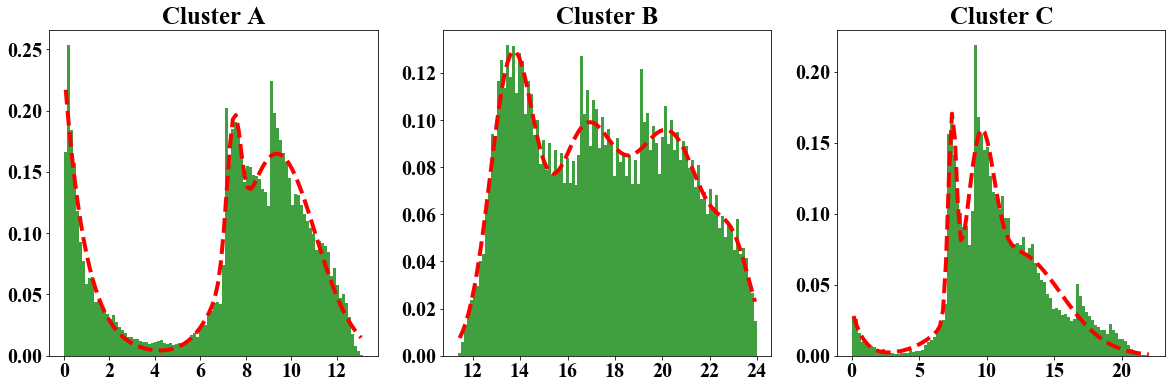

In [96]:
Params={'mu1':0.0,'sigma1':0.0,'A1':0.0,\
        'mu2':0.0,'sigma2':0.0,'A2':0.0,\
        'mu3':0.0,'sigma3':0.0,'A3':0.0,\
        'mu4':0.0,'sigma4':0.0,'A4':0.0,\
        'min':0.0,'max':0.0}

Labels=['A','B','C']

First_shift_start_time={label:{} for label in Labels}

Cols=['mu1','sigma1','A1','mu2','sigma2','A2',\
      'mu3','sigma3','A3','mu4','sigma4','A4']

multipliers={'A':3,'B':4,'C':4}

bars={'A':100,'B':100,'C':100}

Cut_points={'A':[[0,6],[4,10],[10,12]],\
            'B':[[12,16],[16,19],[19,22],[22,24]],\
            'C':[[0,4],[4,9],[9,12],[12,24]]}


'''figures initialization'''

figsize = 20,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(1,3,figsize=figsize)

for i in range(3):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
for i in range(len(Labels)):
    
    label=Labels[i]

    Array=copy.deepcopy(np.array(Clustered_DF.loc[Clustered_DF['label']==label,'First Shift Start Hour'].to_list()))

    Array.sort()

    First_shift_start_time[label]['min'] = Array[int(0.01 * len(Array))]

    First_shift_start_time[label]['max'] = Array[int(0.99 * len(Array))]

    Y, X, _ = ax1[i].hist(Array,bars[label],label='Histogram',facecolor='g', density=True, alpha=0.75)

    X=(X[1:]+X[:-1])/2
    
    Array=Array[int(0.01 * len(Array)):int(0.99 * len(Array))+1]
    
    expected=Get_expected(Array,Cut_points[label])
    
    Y_,params=Get_fit_with_guess(X,Y,multipliers[label],expected)

    ax1[i].plot(X,Y_,'r--',lw=4,label='model')

    ax1[i].set_title('Cluster '+ label,font_label)

    print('Cluster '+label+' P-Value:', ks_2samp(Y,Y_).pvalue)
    
    Params_temp={}

    for i in range(len(params)):

        First_shift_start_time[label][Cols[i]]=params[i]


np.save(os.path.join(Save_Path,'First_shift_start_time.npy'),First_shift_start_time)

First_shift_start_time

## 03 Shift Duration

In [103]:
Get_hour=lambda x:int(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[11:13])+float(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(x))[14:16])/60.0

Get_3600=lambda x:round(x/3600.0,2)

Duration=pd.read_csv(os.path.join(Load_Path,'Duration.csv'))

Duration=Duration.drop(columns=['Unnamed: 0'])

Duration['Shift Duration (hour)']=Duration.apply(lambda x:Get_3600(x['Shift Duration (sec)']),axis=1)

Duration['Shift Start Hour']=Duration.apply(lambda x:Get_hour(x['Shift Start Time']),axis=1)

Duration=Duration[['Driver_id','Shift Start Hour','Shift Duration (hour)']]

Duration=Duration.merge(Driver_DF,on='Driver_id')

Duration



,Driver_id,Shift Start Hour,Shift Duration (hour),label
0,0000131d486b69eb77ab6e9e7cca9f4c,11.950000,0.87,A
1,000211a97ba2b768ef941593bf1ae1a5,9.483333,0.27,A
2,000211a97ba2b768ef941593bf1ae1a5,20.100000,1.74,A
3,000770ada4aa5d856b5a766fb6bf7cf1,9.066667,3.24,A
4,0007a380800445346fff19afc4071ce3,9.500000,0.39,A
5,0008c9d2ac91c00ef8b3ef80eba02a06,10.383333,1.13,A
6,0008c9d2ac91c00ef8b3ef80eba02a06,15.200000,1.09,A
7,0008c9d2ac91c00ef8b3ef80eba02a06,21.066667,3.04,A
8,00095da02ea38d4d8eaa120201e38ae9,9.866667,0.42,A
9,000d0e4bd461b1f964daeb6d21868757,2.933333,1.99,C


In [104]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


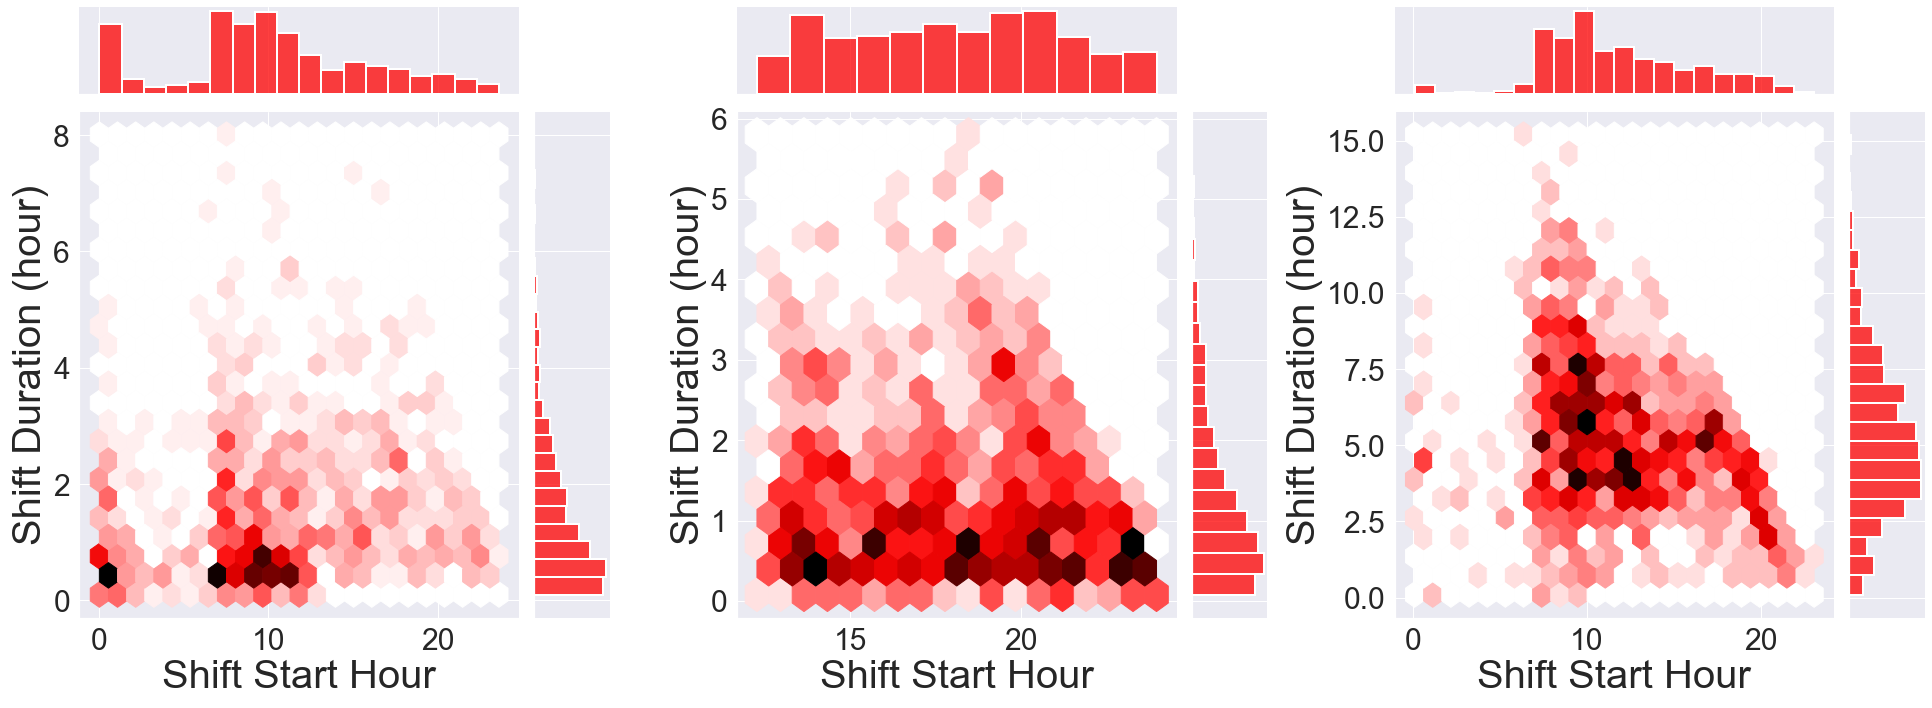

In [115]:
fig = plt.figure(figsize=(27, 10))

gs = gridspec.GridSpec(1, 3)


sns.set(rc={'axes.labelsize':40,
            'xtick.labelsize':30,
            'ytick.labelsize':30})



p1 = sns.jointplot(x='Shift Start Hour',\
              y='Shift Duration (hour)',\
              data=Duration.loc[Duration['label']=='A'].iloc[:1000],\
              color='red',\
              kind='hex',\
              space=0,
              ratio=5,\
              marginal_kws={'lw':2,
                            'color':'red'})

p2 = sns.jointplot(x='Shift Start Hour',\
              y='Shift Duration (hour)',\
              data=Duration.loc[Duration['label']=='B'].iloc[:1000],\
              color='red',\
              kind='hex',\
              space=0,
              ratio=5,\
              marginal_kws={'lw':2,
                            'color':'red'})

p3 = sns.jointplot(x='Shift Start Hour',\
              y='Shift Duration (hour)',\
              data=Duration.loc[Duration['label']=='C'].iloc[:1000],\
              color='red',\
              kind='hex',\
              space=0,
              ratio=5,\
              marginal_kws={'lw':2,
                            'color':'red'})

mg0 = SeabornFig2Grid(p1, fig, gs[0])
mg1 = SeabornFig2Grid(p2, fig, gs[1])
mg2 = SeabornFig2Grid(p3, fig, gs[2])

gs.tight_layout(fig)

plt.show()

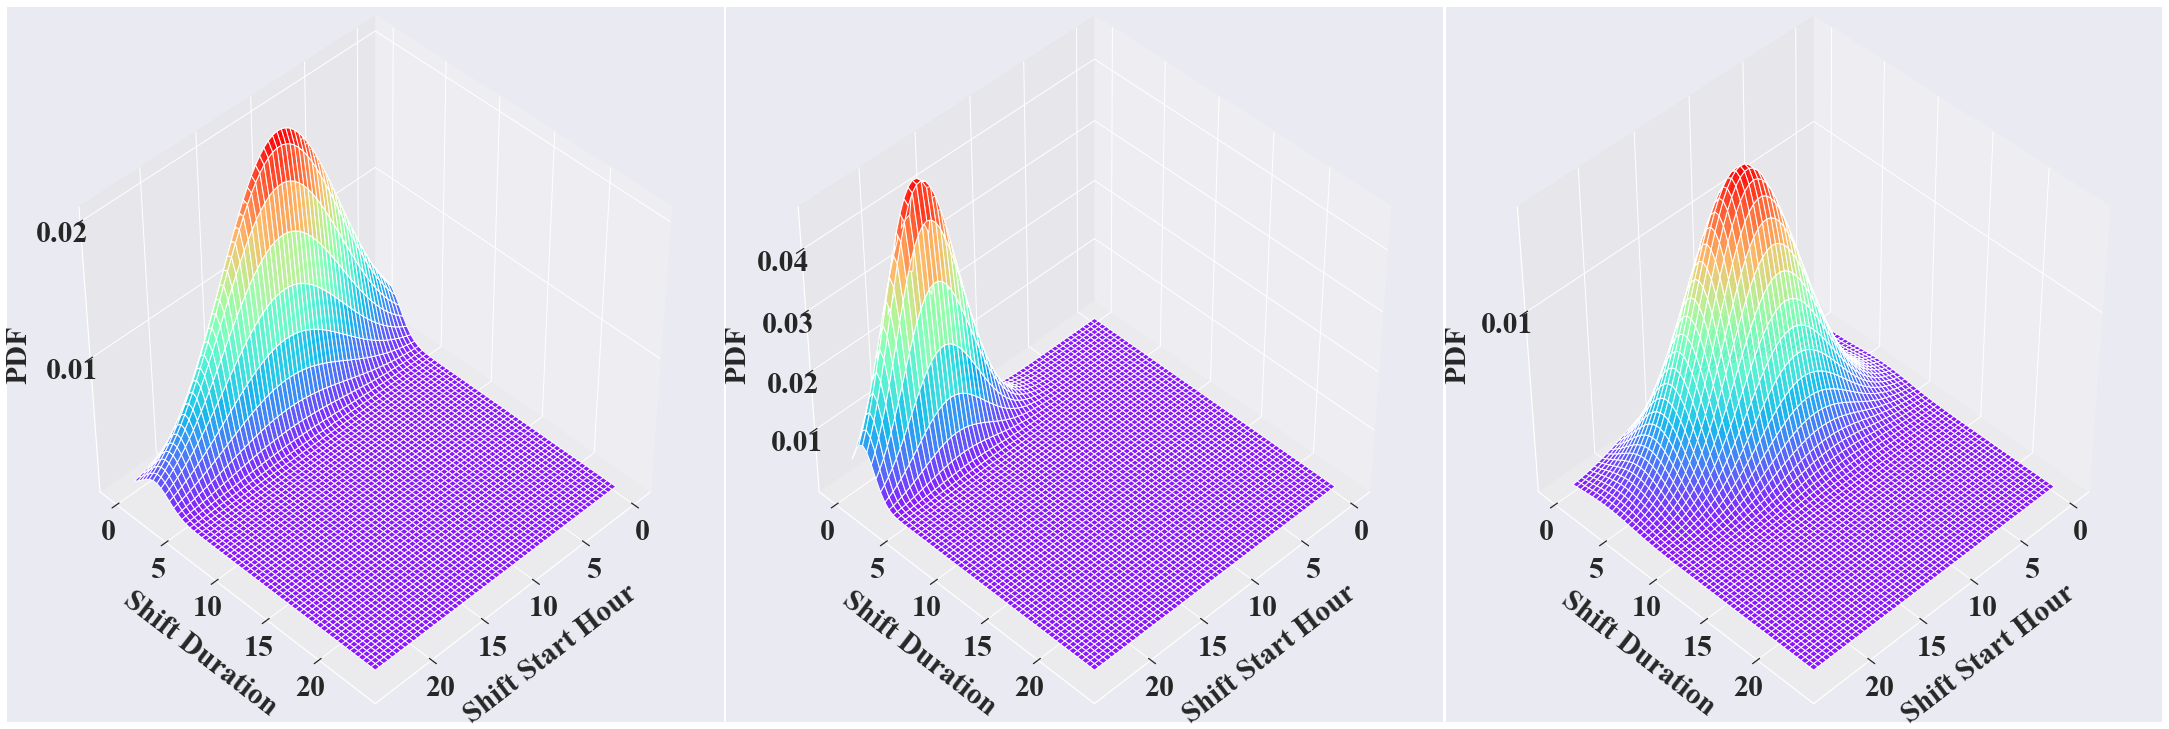

{'A': {'mu_1': 10.710770769060465,
  'mu_2': 1.6251099276614378,
  'std_1': 5.768722500441917,
  'std_2': 1.360130026132657,
  'Sigma': 0.18474684164210517,
  'min_y': 0.23,
  'max_y': 4.37},
 'B': {'mu_1': 17.792945260509043,
  'mu_2': 1.3976192641775431,
  'std_1': 3.1869689523445635,
  'std_2': 1.077319206766281,
  'Sigma': -0.11943712170021195,
  'min_y': 0.23,
  'max_y': 3.58},
 'C': {'mu_1': 11.90305069157027,
  'mu_2': 5.279784357423326,
  'std_1': 4.217926855232252,
  'std_2': 2.5408013599363044,
  'Sigma': -0.2554526706312282,
  'min_y': 1.3,
  'max_y': 9.96}}

In [126]:
'''Bi-variate Gaussian distribution'''

Duration_Param={label:{} for label in Labels}

for i in range(len(Labels)):
    
    label=Labels[i]

    x = np.array(Duration.loc[Duration['label']==label,'Shift Start Hour'])

    y = np.array(Duration.loc[Duration['label']==label,'Shift Duration (hour)'])


    u1 = x.mean()
    u2 = y.mean()
    o1 = x.std()
    o2 = y.std()
    
    Duration_Param[label]['mu_1']=u1
    Duration_Param[label]['mu_2']=u2
    
    Duration_Param[label]['std_1']=o1
    Duration_Param[label]['std_2']=o2

    p = pearsonr(x, y)[0]
    
    Duration_Param[label]['Sigma']=p
    
    y.sort()
    
    Duration_Param[label]['min_y'] = y[int(0.05 * len(y))]
    Duration_Param[label]['max_y'] = y[int(0.95 * len(y))]
    

'''Plot'''

font_label = {'family' : 'Times New Roman',\
              'weight' : 'normal',\
              'size': 30,\
              'rotation':'vertical'}

mpl.rcParams['font.sans-serif'] = ['SimHei']

mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(30,10))

for i in range(len(Labels)):
    
    label=Labels[i]
    
    u1=Duration_Param[label]['mu_1']
    
    u2=Duration_Param[label]['mu_2']
    
    o1=Duration_Param[label]['std_1']
    
    o2=Duration_Param[label]['std_2']
    
    p=Duration_Param[label]['Sigma']
    
    X_arr=np.arange(0.0,24.0,0.4)

    Y_arr=np.arange(0.0,24.0,0.4)

    X, Y = np.meshgrid(X_arr, Y_arr)

    z = (1/(2*np.pi*o1*o2*pow(1-pow(p,2),0.5)))*np.exp(-1/(2*(1-p*p))*(((X-u1)*(X-u1))/(o1*o1)-2*p*(X-u1)*(Y-u2)/(o1*o2)+(Y-u2)*(Y-u2)/(o2*o2)))

    '''Plot'''
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    labels = ax.get_xticklabels() + ax.get_yticklabels()+ ax.get_zticklabels()

    [label.set_fontsize(30) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]

    ax.plot_surface(X, Y, z, cmap='rainbow', rstride=1, cstride=1, alpha=0.9, lw=1)

    ax.set_xlabel("Shift Start Hour",font_label,labelpad=25)

    ax.set_ylabel("Shift Duration",font_label,labelpad=25)

    ax.set_zlabel("PDF",font_label,labelpad=25)

    ax.view_init(45,45)
    
    zmajorLocator   = MultipleLocator(0.01)

    ax.zaxis.set_major_locator(zmajorLocator) 


plt.tight_layout(0.2)

plt.show()
    

np.save(os.path.join(Save_Path,'Duration_Param.npy'),Duration_Param)

Duration_Param



In [139]:
Duration_Stat=copy.deepcopy(Duration)

Duration_Stat=Duration_Stat.round({'Shift Start Hour': 0})

def Get_sort(arr):
    
    arr=np.array(arr)
    
    arr.sort()
    
    arr[int(0.05 * len(arr)):int(0.95 * len(arr))+1]
    
    return arr

def KS_Test(arr):

    figure, ax = plt.subplots(figsize=figsize)

    Y, X, _ = ax.hist(arr, 100,label='Histogram',facecolor='g', density=True, alpha=0.0)
    
    plt.close()
    
    X=(X[1:]+X[:-1])/2
    
    mu=np.mean(arr)
    
    sigma=np.std(arr)
    
    Y_=np.array([gauss(x,mu,sigma,1) for x in X])
    
    return round(ks_2samp(Y,Y_).pvalue,3)

Duration_Df=pd.DataFrame([])

Duration_Df['Shift Duration (hour)']=Duration_Stat.groupby(['Shift Start Hour','label']).apply(lambda x: x['Shift Duration (hour)'].to_list())

Duration_Df['Transition']=Duration_Df.index

Duration_Df['Shift Start Hour']=Duration_Df.apply(lambda x:x['Transition'][0],axis=1)

Duration_Df['label']=Duration_Df.apply(lambda x:x['Transition'][1],axis=1)

Duration_Df=Duration_Df.reset_index(drop=True)

Duration_Df['Shift Duration (hour)']=Duration_Df.apply(lambda x:Get_sort(x['Shift Duration (hour)']),axis=1)

Duration_Df['mean']=Duration_Df.apply(lambda x:np.mean(x['Shift Duration (hour)']),axis=1)

Duration_Df['std']=Duration_Df.apply(lambda x:np.std(x['Shift Duration (hour)']),axis=1)

Duration_Df['max']=Duration_Df.apply(lambda x:x['Shift Duration (hour)'][-1],axis=1)

Duration_Df['min']=Duration_Df.apply(lambda x:x['Shift Duration (hour)'][0],axis=1)

Duration_Df['P-value']=Duration_Df.apply(lambda x:KS_Test(x['Shift Duration (hour)']),axis=1)

Duration_Df=Duration_Df[['Shift Start Hour','Shift Duration (hour)','label','mean','std','max','min','P-value']]


Duration_discrete_Param={label:{h:{'mean':0.0,'std':0.0,'min':0.0,'max':0.0} for h in range(25)} for label in Labels}

for idx,row in Duration_Df.iterrows():
    
    label=row['label']
    
    h=row['Shift Start Hour']
    
    Duration_discrete_Param[label][h]['min']=row['min']
    Duration_discrete_Param[label][h]['max']=row['max']
    Duration_discrete_Param[label][h]['mean']=row['mean']
    Duration_discrete_Param[label][h]['std']=row['std']
    
np.save(os.path.join(Save_Path,'Duration_discrete_Param.npy'),Duration_discrete_Param)

Duration_discrete_Param

                                  
                                  

{'A': {0: {'mean': 0.9848851259709834,
   'std': 0.994615290663752,
   'min': 0.07,
   'max': 8.99},
  1: {'mean': 0.9705759051450351,
   'std': 0.9987042296763805,
   'min': 0.07,
   'max': 9.22},
  2: {'mean': 0.9597818307745585,
   'std': 0.9838426365854702,
   'min': 0.07,
   'max': 13.56},
  3: {'mean': 1.0022426966292133,
   'std': 1.0191126364722634,
   'min': 0.07,
   'max': 11.25},
  4: {'mean': 1.1222640099626402,
   'std': 1.130675760884356,
   'min': 0.08,
   'max': 9.54},
  5: {'mean': 1.3034546488484504,
   'std': 1.2143079254659597,
   'min': 0.07,
   'max': 8.0},
  6: {'mean': 1.4083131844687815,
   'std': 1.285740199854909,
   'min': 0.07,
   'max': 9.22},
  7: {'mean': 1.6599711506454118,
   'std': 1.3523081297218957,
   'min': 0.07,
   'max': 11.37},
  8: {'mean': 1.613999167033018,
   'std': 1.2823080069028674,
   'min': 0.07,
   'max': 10.36},
  9: {'mean': 1.4578790428117405,
   'std': 1.280271647812707,
   'min': 0.07,
   'max': 10.83},
  10: {'mean': 1.507432675

## 04 Shift Gap

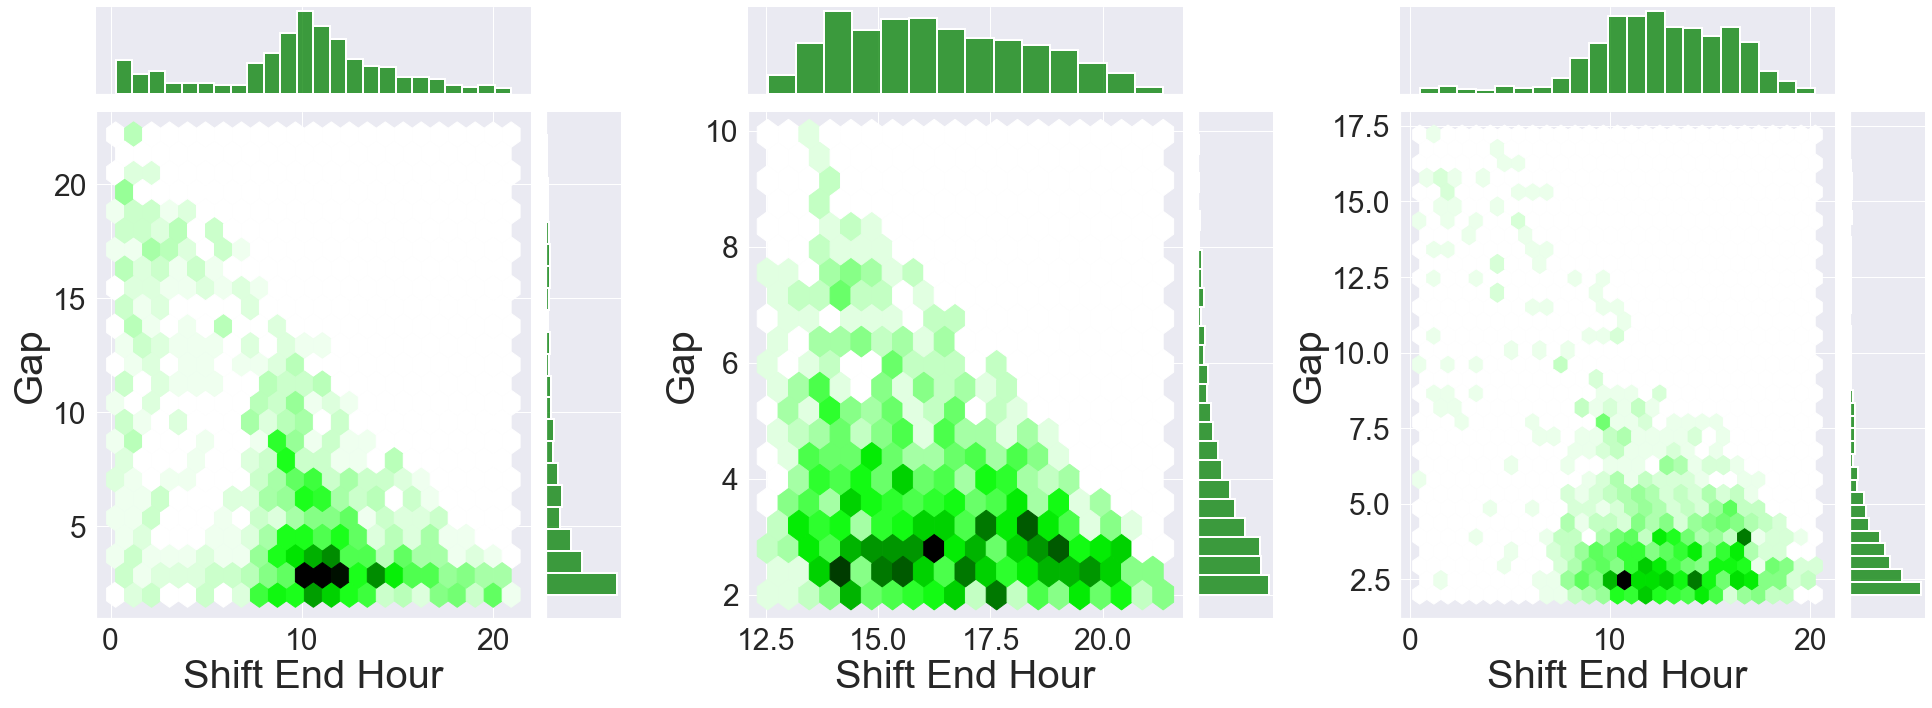

In [151]:
Gap_DF=pd.read_csv(os.path.join(Load_Path,'Gap.csv'))

Gap_DF=Gap_DF.drop(columns=['Unnamed: 0'])

Gap_DF=Gap_DF.merge(Driver_DF,on='Driver_id')



fig = plt.figure(figsize=(27, 10))

gs = gridspec.GridSpec(1, 3)


sns.set(rc={'axes.labelsize':40,
            'xtick.labelsize':30,
            'ytick.labelsize':30})



p1 = sns.jointplot(x='Shift End Hour',\
              y='Gap',\
              data=Gap_DF.loc[Gap_DF['label']=='A'].iloc[:1000],\
              color='green',\
              kind='hex',\
              space=0,
              ratio=5,\
              marginal_kws={'lw':2,
                            'color':'green'})

p2 = sns.jointplot(x='Shift End Hour',\
              y='Gap',\
              data=Gap_DF.loc[Gap_DF['label']=='B'].iloc[:1000],\
              color='green',\
              kind='hex',\
              space=0,
              ratio=5,\
              marginal_kws={'lw':2,
                            'color':'green'})

p3 = sns.jointplot(x='Shift End Hour',\
              y='Gap',\
              data=Gap_DF.loc[Gap_DF['label']=='C'].iloc[:1000],\
              color='green',\
              kind='hex',\
              space=0,
              ratio=5,\
              marginal_kws={'lw':2,
                            'color':'green'})

mg0 = SeabornFig2Grid(p1, fig, gs[0])
mg1 = SeabornFig2Grid(p2, fig, gs[1])
mg2 = SeabornFig2Grid(p3, fig, gs[2])

gs.tight_layout(fig)

plt.show()

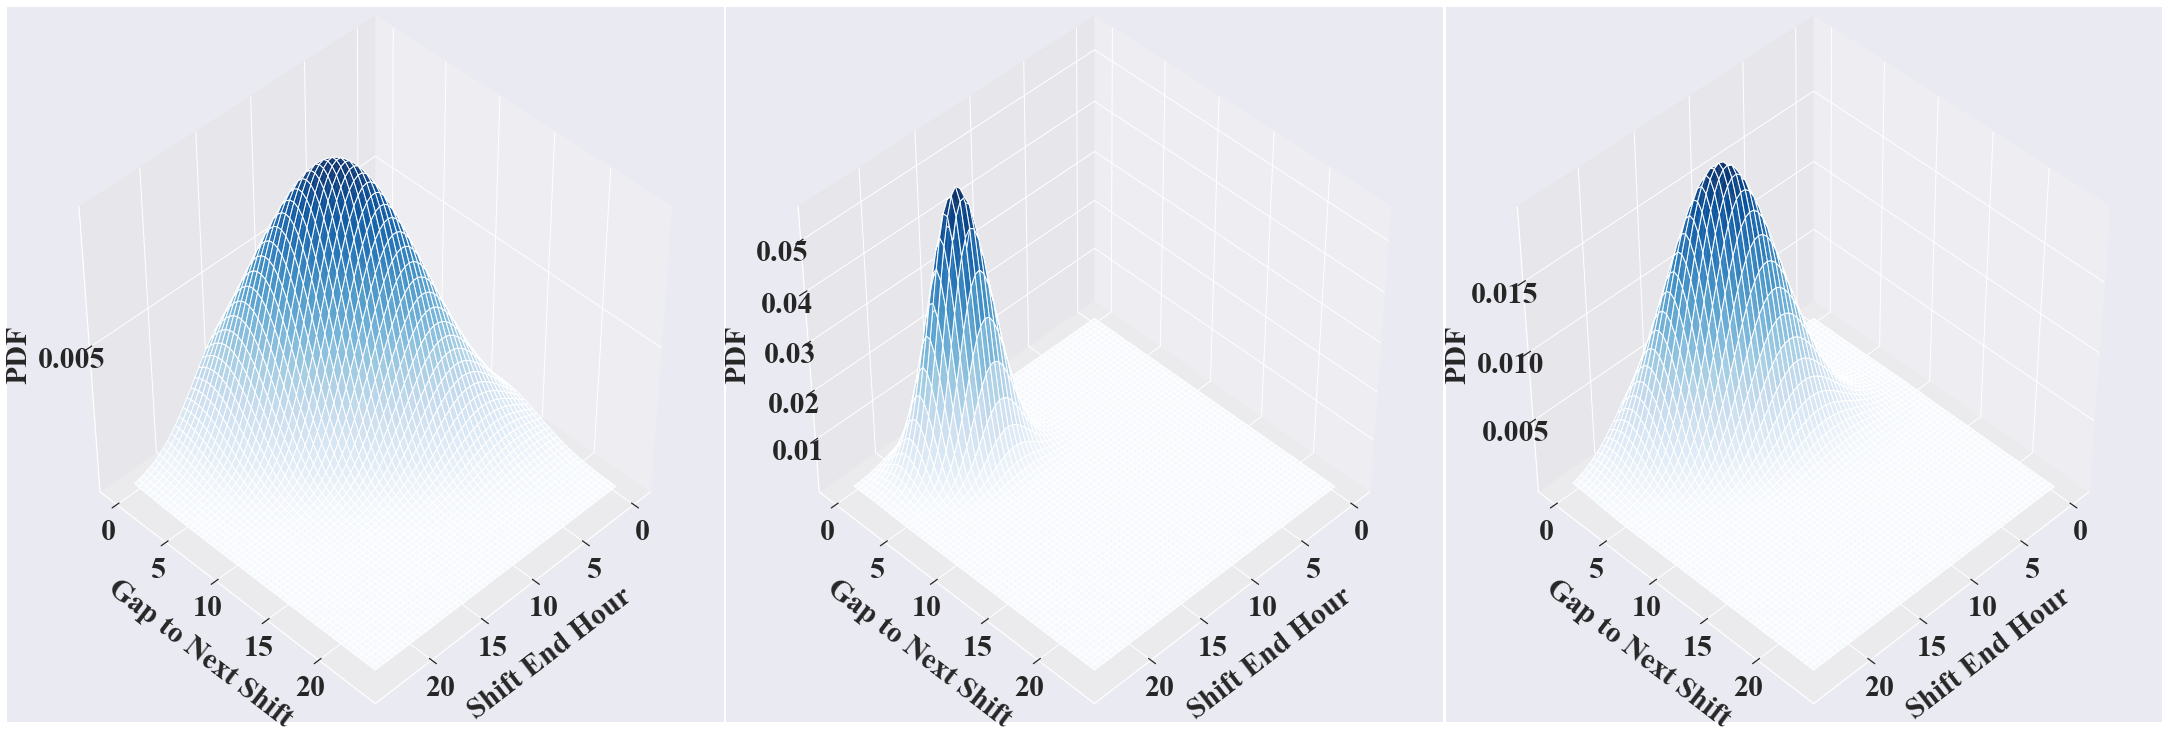

{'A': {'mu_1': 9.960276889976445,
  'mu_2': 6.2385706884067025,
  'std_1': 4.707385749969734,
  'std_2': 4.655874725157104,
  'Sigma': -0.6475289913234024,
  'min_y': 2.15,
  'max_y': 17.38},
 'B': {'mu_1': 16.369043010752687,
  'mu_2': 3.6148100358422943,
  'std_1': 2.1215329361913797,
  'std_2': 1.4644389275472602,
  'Sigma': -0.3765991048098837,
  'min_y': 2.08,
  'max_y': 6.63},
 'C': {'mu_1': 12.680337336335585,
  'mu_2': 4.090874405804354,
  'std_1': 3.721271603116168,
  'std_2': 2.5644488705168307,
  'Sigma': -0.536648474690594,
  'min_y': 2.09,
  'max_y': 9.2}}

In [155]:
'''Bi-variate Gaussian distribution'''

Gap_Param={label:{} for label in Labels}

for i in range(len(Labels)):
    
    label=Labels[i]

    x = np.array(Gap_DF.loc[Gap_DF['label']==label,'Shift End Hour'])

    y = np.array(Gap_DF.loc[Gap_DF['label']==label,'Gap'])


    u1 = x.mean()
    u2 = y.mean()
    o1 = x.std()
    o2 = y.std()
    
    Gap_Param[label]['mu_1']=u1
    Gap_Param[label]['mu_2']=u2
    
    Gap_Param[label]['std_1']=o1
    Gap_Param[label]['std_2']=o2

    p = pearsonr(x, y)[0]
    
    Gap_Param[label]['Sigma']=p
    
    y.sort()
    
    Gap_Param[label]['min_y'] = y[int(0.05 * len(y))]
    Gap_Param[label]['max_y'] = y[int(0.95 * len(y))]
    

'''Plot'''

font_label = {'family' : 'Times New Roman',\
              'weight' : 'normal',\
              'size': 30,\
              'rotation':'vertical'}

mpl.rcParams['font.sans-serif'] = ['SimHei']

mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(30,10))

zticks=[0.005,0.01,0.005]

for i in range(len(Labels)):
    
    label=Labels[i]
    
    u1=Gap_Param[label]['mu_1']
    
    u2=Gap_Param[label]['mu_2']
    
    o1=Gap_Param[label]['std_1']
    
    o2=Gap_Param[label]['std_2']
    
    p=Gap_Param[label]['Sigma']
    
    X_arr=np.arange(0.0,24.0,0.4)

    Y_arr=np.arange(0.0,24.0,0.4)

    X, Y = np.meshgrid(X_arr, Y_arr)

    z = (1/(2*np.pi*o1*o2*pow(1-pow(p,2),0.5)))*np.exp(-1/(2*(1-p*p))*(((X-u1)*(X-u1))/(o1*o1)-2*p*(X-u1)*(Y-u2)/(o1*o2)+(Y-u2)*(Y-u2)/(o2*o2)))

    '''Plot'''
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    labels = ax.get_xticklabels() + ax.get_yticklabels()+ ax.get_zticklabels()

    [label.set_fontsize(30) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]

    ax.plot_surface(X, Y, z, cmap='Blues', rstride=1, cstride=1, alpha=0.9, lw=1)

    ax.set_xlabel("Shift End Hour",font_label,labelpad=25)

    ax.set_ylabel("Gap to Next Shift",font_label,labelpad=25)

    ax.set_zlabel("PDF",font_label,labelpad=25)

    ax.view_init(45,45)
    
    zmajorLocator   = MultipleLocator(zticks[i])

    ax.zaxis.set_major_locator(zmajorLocator) 


plt.tight_layout(0.2)

plt.show()
    

np.save(os.path.join(Save_Path,'Gap_Param.npy'),Gap_Param)

Gap_Param




In [148]:
Gap_Df=copy.deepcopy(Gap_DF)

Gap_Df=Gap_Df.round({'Shift End Hour': 0})


Gap_STAT=pd.DataFrame([])

Gap_STAT['Gap']=Gap_Df.groupby(['Shift End Hour','label']).apply(lambda x: x['Gap'].to_list())

Gap_STAT['Transition']=Gap_STAT.index

Gap_STAT['Shift End Hour']=Gap_STAT.apply(lambda x:x['Transition'][0],axis=1)

Gap_STAT['label']=Gap_STAT.apply(lambda x:x['Transition'][1],axis=1)

Gap_STAT=Gap_STAT.reset_index(drop=True)


Gap_STAT['Gap']=Gap_STAT.apply(lambda x:Get_sort(x['Gap']),axis=1)

Gap_STAT['mean']=Gap_STAT.apply(lambda x:np.mean(x['Gap']),axis=1)

Gap_STAT['std']=Gap_STAT.apply(lambda x:np.std(x['Gap']),axis=1)

Gap_STAT['max']=Gap_STAT.apply(lambda x:x['Gap'][-1],axis=1)

Gap_STAT['min']=Gap_STAT.apply(lambda x:x['Gap'][0],axis=1)

Gap_STAT['P-value']=Gap_STAT.apply(lambda x:KS_Test(x['Gap']),axis=1)


Gap_STAT=Gap_STAT[['Shift End Hour','Gap','label','mean','std','max','min','P-value']]



Gap_discrete_Param={label:{h:{'mean':0.0,'std':0.0,'min':0.0,'max':0.0} for h in range(25)} for label in Labels}

for idx,row in Gap_STAT.iterrows():
    
    label=row['label']
    
    h=row['Shift End Hour']
    
    Gap_discrete_Param[label][h]['min']=row['min']
    Gap_discrete_Param[label][h]['max']=row['max']
    Gap_discrete_Param[label][h]['mean']=row['mean']
    Gap_discrete_Param[label][h]['std']=row['std']
    
np.save(os.path.join(Save_Path,'Gap_discrete_Param.npy'),Gap_discrete_Param)

Gap_discrete_Param

                                  
                                  

{'A': {0: {'mean': 13.327915570437693,
   'std': 5.893754803100577,
   'min': 2.0,
   'max': 23.26},
  1: {'mean': 12.965325036115123,
   'std': 5.983902167105554,
   'min': 2.0,
   'max': 22.64},
  2: {'mean': 12.608729676612471,
   'std': 5.8727040441710985,
   'min': 2.0,
   'max': 21.68},
  3: {'mean': 11.747238410596028,
   'std': 5.945167261259555,
   'min': 2.0,
   'max': 20.49},
  4: {'mean': 11.479593972373378,
   'std': 5.869633216864966,
   'min': 2.0,
   'max': 19.6},
  5: {'mean': 10.122541567695963,
   'std': 5.621520202193002,
   'min': 2.0,
   'max': 18.5},
  6: {'mean': 8.529600987248045,
   'std': 5.019373938229766,
   'min': 2.0,
   'max': 17.52},
  7: {'mean': 6.5073487211478485,
   'std': 3.815879446815553,
   'min': 2.0,
   'max': 16.52},
  8: {'mean': 6.059099609524538,
   'std': 3.180449354650531,
   'min': 2.0,
   'max': 15.37},
  9: {'mean': 5.513534781240164,
   'std': 2.7537723349113934,
   'min': 2.0,
   'max': 14.65},
  10: {'mean': 4.833240814696486,
   '